# Credits

Originally created for a previous version of the [02456-deep-learning](https://github.com/DeepLearningDTU/02456-deep-learning) course material, but [converted to PyTorch](https://github.com/pytorch/tutorials).
See repos for credits.

In [1]:
## Install pandas if you don't already have it (uncommet line below)

# !pip3 install pandas

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Tying everything together

Now that you have learned about the three most used network architectures: FFNs, CNNs and RNNs. It is time to combine these network types into a more advanced model. 
It often happens that you have a combination of data that cannot fully be modeled by any one of these three types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](kaggle.com) that contains several different kinds of data.
First we will download the data and visualize it, and then we will train a network to classify the data.
A simple network with poor performance in provided for you as a starting point, but it is up to you use the things you have learnt to improve the results.


## Kaggle challenge
Kaggle is a website to participate in real life challenges.
Early 2017 it was bought by Google, who wanted access to the global community of data scientists it has created over the last 7 years.
Since then Google have sponsored its expansion and now the prizes of the competitions and the amount of public datasets are bigger than ever. 
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

The challenge we will pursue is the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge.
The dataset consists approximately 1,584 images of leaf specimens (16 samples each of 99 species) which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.

We will primarily look into the type of neural network best suited for handling this type of data. 
 * For images, usually the convolutional neural network does a pretty good job, 
 * For timeseries (like the shape) usually the RNN is the network of choice
 * For the describing features a FFN is often a good option

Lastly, we will train the model and put the outputs in a submission file that we can submit to Kaggle.

# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create a user
1. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
1. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [3]:
image_paths = glob.glob("images/*.jpg")
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]

# notice how we "only" have 990 images for training, the rest is for testing
print("Training data shape:\t", train.shape)

# now do similar as in train example above for test.csv
test = pd.read_csv('test.csv')
# notice that we do not have species here, we need to predict that ..!
print("Test data shape:\t", test.shape) 

Total Observations:	 1584
Training data shape:	 (990, 194)
Test data shape:	 (594, 193)


With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at the 99 different categories and come up with a system that discern all 99 types of leaves from each other. 

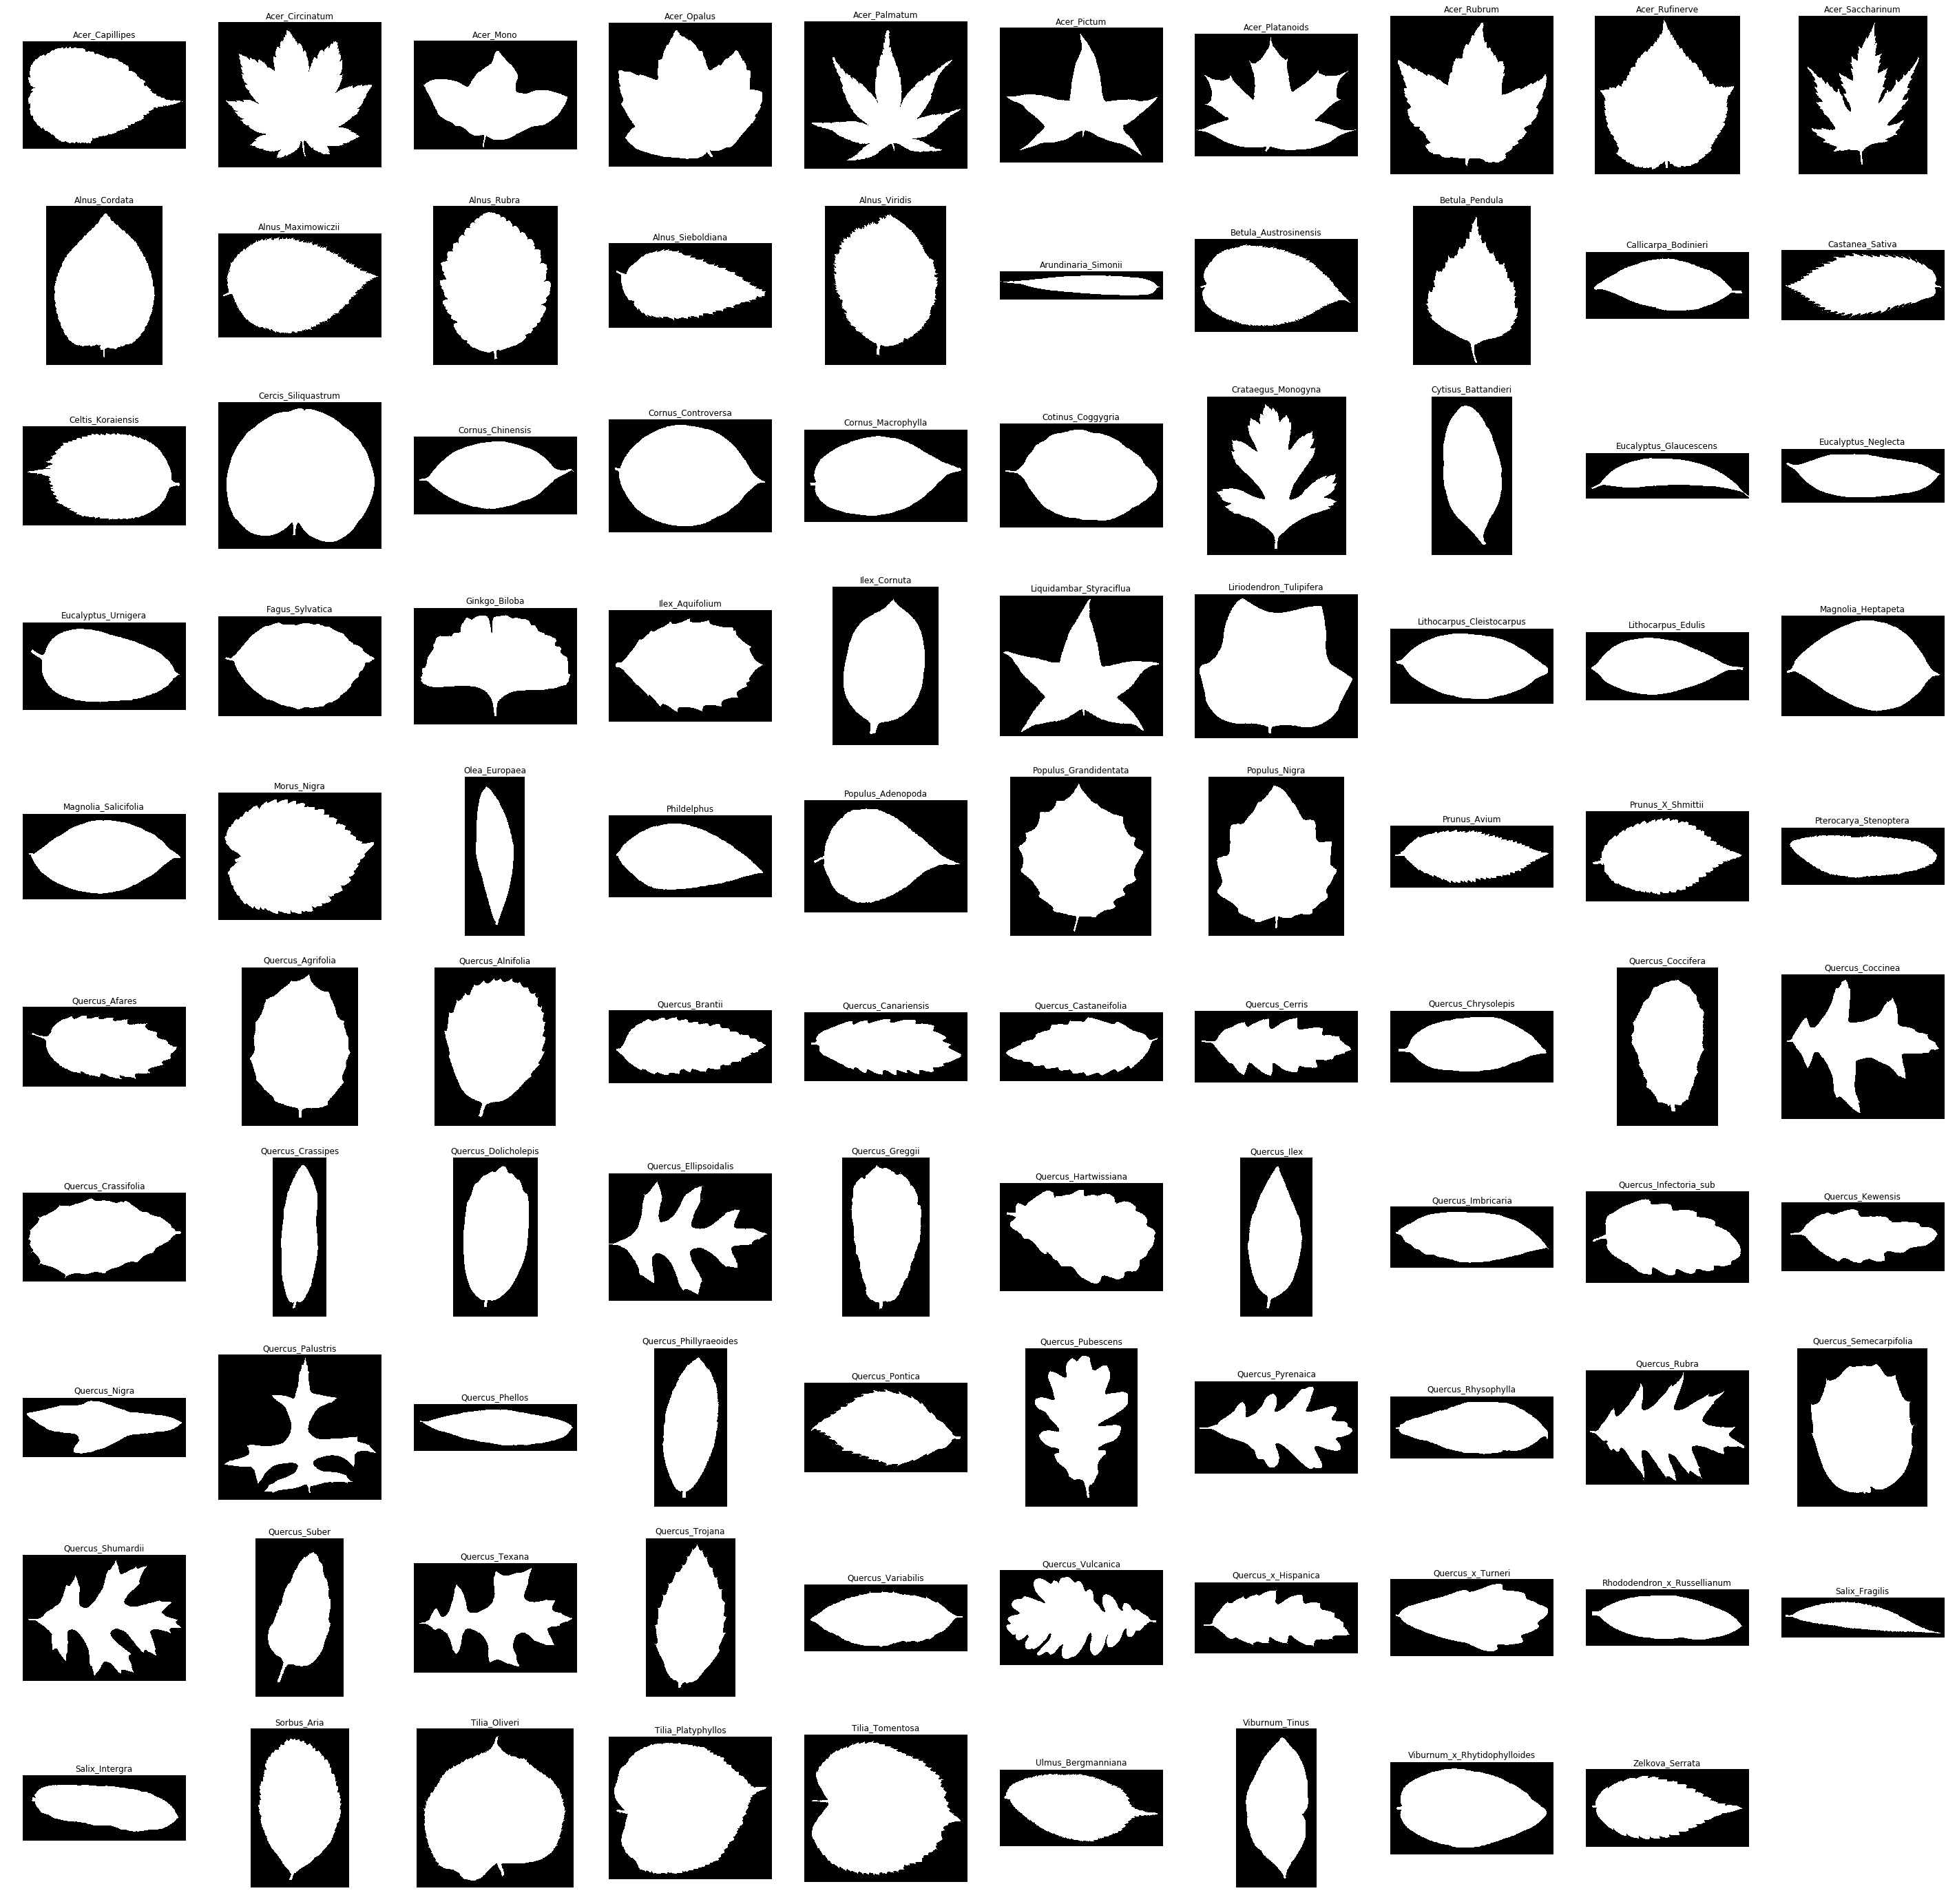

In [4]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its' index in our list of images in order to find the correct image
indexes = [image_paths.index('images/{}.jpg'.format(i)) for i in species_examples]

# now plot 1 image from each category
fig = plt.figure(figsize=(50, 50))
for i, idx in enumerate(indexes):
    plt.subplot(10, 10, i + 1)
    image = imread(image_paths[idx], as_gray=True)
    plt.imshow(image, cmap='gray')
    plt.title("%s" % (species[i]))
    plt.axis('off')
plt.show()

As you can see, classifying leaves is actually a very tough problem.
What makes it even worse, is that we cannot use all the image data we have available.
In order to decrease the amount of computations needed, we need to reduce the size of the images as much as possible.
On top of that our neural network usually only accepts fixed size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.
This means we will have to change the shape of the images so that they all have the same sizes.

Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its' shape into account seems extremely difficult.

Therefore we will first pad all the images into squares, and then resize them, as visualized below:

## Exercise 1

1.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is to small should ultimately be determined by an actual test, but what makes visual sense is a good place to start.
Change the `image_size=(?, ?)` parameter below, and note your choice.
 * **Answer:** I chose 40 x 40. This seemed to give a nice compromise between a small image size (giving speed), and still being able to see some of the finer details of image. The very fine edge details are gone, but my hope is that the `shape` data can make up for this.


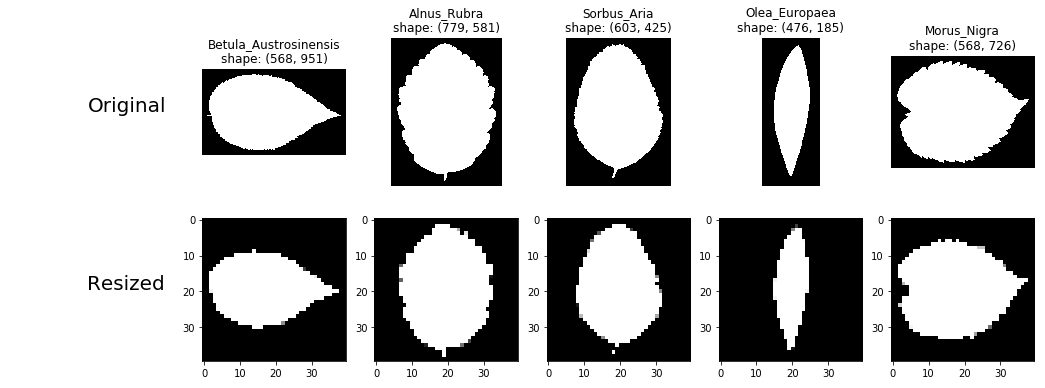

In [5]:
## Image pre-processing
image_size = (40, 40)  # <-- YOUR CODE HERE


fig = plt.figure(figsize=(18, 6))
amount = 5
image_sample = np.random.choice(train_images, amount)
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=False)  # resizes the image
    plt.imshow(image, cmap='gray')
    
plt.show()

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Try to run it a few times to try and get an understanding of how the features differ from species to species.

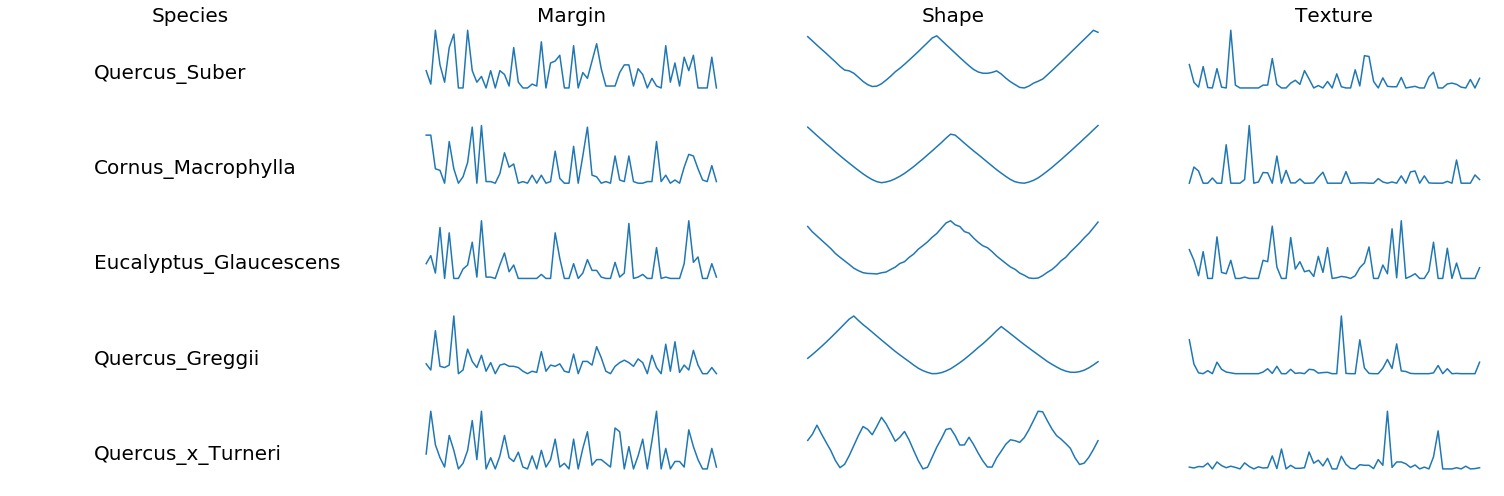

In [6]:
# try and extract and plot columns
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5 # Choose the amount of images we want to show at a time
for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

We can see that `margin` and `texture` are feature vectors where the elements don't seem to have an connection with their neighbors.
`shape` on the other hand clearly have a sequential structure where the elements have a strong correlation with their neighborurs. 

## Exercise 2
So far we have learned about the feed forward neural network (FFNN), the convolutional neural network (CNN) and the recurrent neural network (RNN).

2.1) How could `Margin`, `Shape` and `Texture` be used for classification? I.e. What kind of network type would you use for each of them, and why?
 * **Answer:** For `shape` I would use an RNN, since it has a sequential structure. However, maybe one could also achieve nice results using a 1D CNN. For `margin` and `texture` I would use a FFNN since it is essentially a feature vector.

# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you going to work on your own projects.


## Defining the data loader

In [7]:
# loading data and setting up constants
IMAGE_SHAPE = image_size + (1, )

TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
IMAGE_PATHS = glob.glob("images/*.jpg")
NUM_CLASSES = 99
NUM_FEATURES = 64 # for all three features, margin, shape and texture
# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
# print
print("\n@@@Shape checking of data sets@@@")
# print
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
# print()
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594

@@@Shape checking of data sets@@@
TRAIN
	images	(990, 40, 40, 1)0.279986
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 40, 40, 1)	0.280267
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

In [8]:
batch_size = 64
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=99, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))
# notice that mean is very different, which is why we use batch_norm in all input data in model

TRAIN
	images, (64, 40, 40, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

VALID
	images, (64, 40, 40, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

TEST
	images, (64, 40, 40, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ids, 64


# Build the model

In [9]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, LSTM, Conv2d, Dropout, MaxPool2d, BatchNorm1d, ReLU
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [10]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

print('use_cuda:', use_cuda)

use_cuda: True


In [112]:
height, width, channels = IMAGE_SHAPE

conv_out_channels_1 = 64
conv_out_channels_2 = 128
conv_stride = 1
kernel_size = 5
pool_stride = 2

img_conv_out = 7*7*conv_out_channels_2
img_fc_out = 256
rnn_out = 100
margin_texture_len = 64 + 64
margin_texture_out = 256
features_cat_size = img_fc_out + rnn_out + margin_texture_out

features_rnn_size = NUM_FEATURES+NUM_FEATURES+100  # size of output of RNN

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
#         # conv layer with (5, 5) kernel, stride of 1, and padding 2 (gives same dim output)
        self.img_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=conv_out_channels_1,
                kernel_size=kernel_size,
                stride=conv_stride,
                padding=0),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(
                kernel_size=2,
                stride=pool_stride,
                padding=0),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=conv_out_channels_1,
                out_channels=conv_out_channels_2,
                kernel_size=kernel_size,
                stride=conv_stride,
                padding=0),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(
                kernel_size=2,
                stride=pool_stride,
                padding=0),
            nn.ReLU()
        )
    
        self.img_fc = nn.Sequential(
            nn.Linear(
                in_features=img_conv_out,
                out_features=img_fc_out,
                bias=True),
            nn.BatchNorm1d(img_fc_out),
            nn.ReLU()
        )
        
        self.features_fc = nn.Sequential(
            nn.Linear(
                in_features=margin_texture_len,
                out_features=512,
                bias=True),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(
                in_features=512,
                out_features=256,
                bias=True),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(
                in_features=256,
                out_features=margin_texture_out,
                bias=True),
            nn.BatchNorm1d(margin_texture_out),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.seq_rnn = nn.LSTM(
            input_size=1,
            hidden_size=rnn_out,
            num_layers=1,
            batch_first=True,
            bidirectional=False)

        self.final_fc = nn.Sequential(
            nn.Linear(
                in_features=features_cat_size,
                out_features=1024,
                bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(
                in_features=1024,
                out_features=1024,
                bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(
                in_features=1024,
                out_features=NUM_CLASSES,
                bias=True),
            nn.BatchNorm1d(NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## use concatenated leaf features
        x = torch.cat((x_margin, x_texture), dim=1)  # if you want to use features as feature vectors
        x = self.features_fc(x)
        features_vector = x
        features.append(features_vector)
        
        ## image features
        x = x_img.permute(0, 3, 1, 2)  # permute the dimensions, such that we have NCHW (num, channels, heigh, width)
        x = self.img_conv(x)
        
        x = x.view(x.shape[0], -1)
        features_img = self.img_fc(x)
        features.append(features_img)
        
        ## use concatenated leaf features, where shape has been through an rnn
        x_shape.unsqueeze_(-1)
        _, (hs, cs) = self.seq_rnn(x_shape)  # note, hs gives (num_layers * num_directions, batch, hidden_size)
        hs = hs.permute(1, 0, 2)  # so, we need to move batch dim to first element
        hs = hs.contiguous().view(hs.shape[0], -1)
        features_rnn = hs
        features.append(features_rnn)
        
        features_final = torch.cat(features, dim=1)
        out['out'] = self.final_fc(features_final)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (img_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): Dropout2d(p=0.2)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (5): Dropout2d(p=0.2)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
  )
  (img_fc): Sequential(
    (0): Linear(in_features=6272, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (features_fc): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, 

# Build the cost function

In [113]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()
#def criterion(input_, target):
#    return -torch.sum(torch.sum(target.float()*input_)) / input_.size()[0]
    
# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=4)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [114]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
print(output['out'].size())
output['out']

torch.Size([64, 99])


tensor([[-4.7535, -5.4340, -4.7166,  ..., -4.8269, -4.6249, -4.9214],
        [-4.6427, -3.4092, -4.7961,  ..., -4.8747, -4.7501, -4.3884],
        [-5.1084, -4.3219, -4.7719,  ..., -4.6918, -5.1722, -5.3280],
        ...,
        [-4.6701, -5.5652, -4.6770,  ..., -4.6748, -5.6993, -4.5697],
        [-5.0863, -4.9749, -4.7801,  ..., -4.8724, -4.7318, -4.9169],
        [-4.5377, -4.2961, -4.8036,  ..., -5.0281, -4.8942, -4.3659]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)

# Train

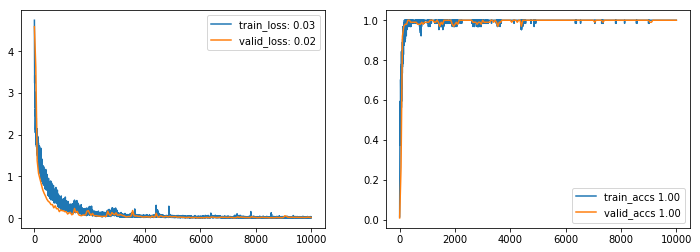

In [115]:
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for valition
max_iter = 10000
log_every = 100
eval_every = 50

def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
        scheduler.step(valid_loss[-1])
    
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss: {:.2f}'.format(train_loss[-1]))
        plt.plot(valid_iter, valid_loss, label='valid_loss: {:.2f}'.format(valid_loss[-1]))
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs {:.2f}'.format(train_accs[-1]))
        plt.plot(valid_iter, valid_accs, label='valid_accs {:.2f}'.format(valid_accs[-1]))
        plt.legend()
        plt.show()
        clear_output(wait=True)
#         print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

## Exercise 3
Now it is your turn!

**Tip** This is very small dataset (number of observations) compared to the number of features.
This means that overfitting will likely be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start out simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred, you can change learning rate, try testing various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you of to a good start we have created a list of **thing you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batchnormalization (a lot)
* Try with L1 or L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you cant. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of final architecture
* Description of training parameters
* Description of final results (Kaggle and validation)

**Answer:** I ended up with the following network (see above cell for the dimensions and exact parameters):
* 'texture' and 'margin' are concatenated into a single vector and fed into a FFNN with 3 layers (see `feature_fc` above). I used ReLU as activation and batch normalization before all activations. After the last activaton I have added a dropout layer.
* 'shape' is fed into a unidirectional LSTM RNN with 1 layer (see `rnn` above).
* The image is fed into a CNN with 2 convolutional layers with dropout, max. pooling, and ReLU activaton (see `img_conv` above). Afterwards there is a fully connected layer with batch normalization and ReLU (see `img_fc` above).
* The output of all the above nets are then concatendated into a single feature vector. This is then fed into a FFNN with 3 layers (see `final_fc` above), using ReLU for activation, log-softmax for the final activation, and batch normalization before all activations. When making the Kaggle submissions the output is first fed into `torch.exp` to convert the output back into probabilities.

I used the ADAM optimizer with a learn rate of 0.001, and weight decay of 0.0005. My batch size was 64. I also used a step length scheduler which decreases the step length with a factor of 0.9 if the validation loss has not decreased for the last 4 times it was evaluated (this happened every 50 iterations). I trained for 10,000 iterations.

My final results are a training- and validation loss of 0.03 and 0.02, respectively, and an accuracy 100% for both. My kaggle score was 0.07759. I tried training several times, but the score kept hovering around 0.7. I think my network classifies correctly, so to increase the score further I would need to make it "more certain" of its decisions. Maybe this could acheived with yet more training, or by switching to L1 loss which would induce more sparsity in the weights - thus forcing the net to make "sharper" decisions.

I tried chaning the batch size, but I did not find that this made any significant difference. Also experimented with different combinations of dropout and batch normalization. I found that the convolutional layers improved the most using dropout, but batch normalization worked better for the fully connected layers. Except for the last layer in `feature_fc`, where adding dropout after the activation gave better performance.

I also found that adding the step size scheduler gave slighty more stable performance, but is step was decreased too aggressively the net would get stuck in a bad posisiton. Also, training for longer seemed to improve performance.

Finally, I also tried using multi-label log loss as my loss function, as that is what the kaggle score was based on. However, this did not give better performance than using cross entropy, which is what I ended up with.

# Submission to Kaggle

First we have to make testset predictions, then we have to place it in the submission file and the upload to Kaggle for our score! You can upload at max 5 submissions a day.

In [119]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out_log = output['out']
    y_out = torch.exp(y_out_log).data

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

## Make submission file

In [120]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv('submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(8)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,6.172158e-07,6.232627e-07,6.039764e-07,7.369655e-07,5.856207e-07,5.622419e-07,5.390207e-07,5.355978e-07,6.390331e-07,...,5.194024e-07,5.996226e-07,6.004437e-07,5.955865e-07,6.415264e-07,6.652324e-07,5.299671e-07,6.431031e-07,6.558959e-07,5.748877e-07
1,7,5.147077e-05,3.823681e-05,5.292635e-05,4.683894e-05,5.197558e-05,4.252870e-05,3.885481e-05,5.382595e-05,3.166634e-05,...,4.082599e-05,6.354052e-05,3.311343e-05,5.595695e-05,3.915178e-05,4.897437e-05,3.696681e-05,5.450736e-05,3.938438e-05,4.462234e-05
2,9,2.006346e-07,9.999809e-01,2.306455e-07,2.064797e-07,2.261930e-07,2.090308e-07,1.840154e-07,2.007739e-07,1.957698e-07,...,1.873932e-07,2.094806e-07,1.818781e-07,2.342526e-07,2.086327e-07,2.359166e-07,1.760169e-07,2.040450e-07,2.186488e-07,1.863191e-07
3,12,2.078747e-05,2.217326e-05,2.328996e-05,2.418048e-05,2.498374e-05,2.113972e-05,1.709327e-05,2.944885e-05,1.226483e-05,...,1.563549e-05,2.890687e-05,1.671711e-05,2.486878e-05,1.906470e-05,2.486406e-05,1.930215e-05,2.500283e-05,2.089240e-05,2.237445e-05
4,13,2.164888e-07,1.583852e-07,2.218517e-07,1.891778e-07,1.892540e-07,1.717392e-07,1.369311e-07,1.998791e-07,1.634558e-07,...,1.338924e-07,2.101808e-07,1.824965e-07,1.750777e-07,1.765503e-07,1.592598e-07,1.280048e-07,1.761499e-07,1.801160e-07,1.708567e-07
5,16,5.894338e-08,4.556103e-08,6.909579e-08,9.999942e-01,6.781586e-08,5.370153e-08,4.848245e-08,5.622282e-08,5.327143e-08,...,4.972570e-08,7.920753e-08,4.987778e-08,7.196827e-08,5.617737e-08,6.362610e-08,5.062702e-08,6.716784e-08,6.289768e-08,5.274085e-08
6,19,4.327045e-09,3.774807e-09,4.819964e-09,1.000000e+00,5.048563e-09,4.338168e-09,4.554667e-09,3.968312e-09,4.197509e-09,...,4.059924e-09,4.874865e-09,4.513228e-09,4.242560e-09,4.807541e-09,5.001055e-09,4.252557e-09,4.850453e-09,4.650998e-09,4.295240e-09
7,23,1.156776e-04,8.569839e-05,9.891510e-05,8.299704e-05,1.021458e-04,9.932478e-05,7.469659e-05,1.008927e-04,7.079750e-05,...,6.779798e-05,1.572366e-04,6.229906e-05,1.320475e-04,6.929399e-05,1.084681e-04,7.586630e-05,1.079311e-04,8.404556e-05,8.575881e-05


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 

# Exercise from the book

I chose the following exercise:
> Prove the identity in Equation (111).

**Answer:** The identity is
$$
\sigma(z) = \frac{1 + \tanh(z/2)}{2}.
$$
We know
$$
\sigma(z) = \frac{e^x}{e^x + 1},
$$
and
$$
\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}.
$$
Insertion gives us
$$
\frac{1 + \tanh(z/2)}{2} = \frac{1}{2}\left( 1 + \frac{e^{z/2} - e^{-z/2}}{e^{z/2} + e^{-z/2}} \right).
$$
Multiplying through with $e^{z/2}$ gives
$$
\frac{1 + \tanh(z/2)}{2} = \frac{1}{2}\left( 1 + \frac{e^z - 1}{e^{z} + 1} \right) = \frac{1}{2}\left( 1 + \frac{e^z}{e^{z} + 1} - \frac{1}{e^{z} + 1} \right).
$$
Rearranging gives
$$
\frac{1 + \tanh(z/2)}{2} = \frac{1}{2}\left( \frac{e^z}{e^{z} + 1} + \frac{e^z + 1}{e^{z} + 1} - \frac{1}{e^{z} + 1} \right) = \frac{1}{2}\left( \frac{e^z}{e^{z} + 1} + \frac{e^z}{e^{z} + 1} \right) = \frac{e^z}{e^{z} + 1} = \sigma(z),
$$
which completes the proof.